# Import library


In [ ]:
!pip install audiomentations

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from scipy import signal
import numpy as np
import librosa
from typing import List
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Clip, Padding, Reverse, Trim, BandPassFilter,Limiter
from audiomentations import BandStopFilter,Gain,TimeMask,HighPassFilter,ClippingDistortion,ClippingDistortion,GainTransition,LowPassFilter,AirAbsorption

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import IPython.display as ipd

In [ ]:
# tạo hàm và cài đặt các thông số cho các phép tăng cường dữ liệu
def get_augs(aug):
    augmentations = []
    if aug == 'NoiseInjection':
        augmentations.append(AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.03, p=1.0))
    elif aug == 'PitchShifting':
        augmentations.append(PitchShift(min_semitones=-2.5, max_semitones=2.5, p=1.0))
    elif aug == 'TimeStretching':
        augmentations.append(TimeStretch(min_rate=1.04, max_rate=1.05, p=1.0))
    elif aug == 'Padding':
        augmentations.append(Padding(min_fraction=0.05,max_fraction=0.08, p=1.0))
    elif aug == 'BandPassFilter':
        augmentations.append(BandPassFilter(min_center_freq=2200, max_center_freq=2400, p=1.0))
    elif aug == 'Gain':
      augmentations.append(Gain(min_gain_in_db=-10, max_gain_in_db=10,p=1.0))
    elif aug == 'TimeMask':
      augmentations.append(TimeMask(min_band_part=0.14, max_band_part=0.18,p=1.0))
    elif aug == 'HighPassFilter':
      augmentations.append(HighPassFilter(min_cutoff_freq=1600, max_cutoff_freq=1800, p=1))
    elif aug == 'ClippingDistortion':
      augmentations.append(ClippingDistortion(min_percentile_threshold =0, max_percentile_threshold=8, p=1))
    elif aug == 'AirAbsorption':
      augmentations.append(AirAbsorption(min_distance=10.0,max_distance=40.0,p=1.0,))
    elif aug == "Trim":
      augmentations.append(Trim(top_db=30.0,p=1.0))
    return augmentations

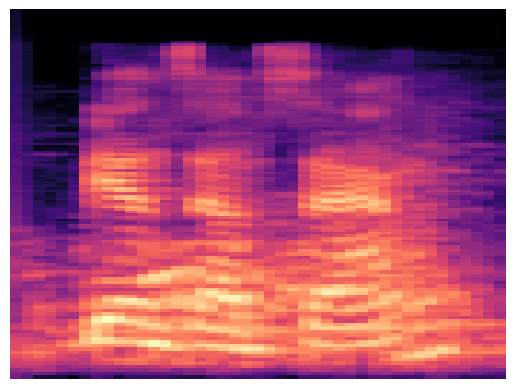

In [ ]:
# vẽ spectrogram của tín hiệu âm thanh gốc
import librosa.display

y, sr = librosa.load('/content/drive/MyDrive/Data_set/dengiamsang/nam/0006_nohash_0.wav')

fig, ax = plt.subplots()
plt.axis('off')
M = librosa.feature.melspectrogram(y=y, sr=sr)
M_db = librosa.power_to_db(M, ref=np.max)
img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=ax)

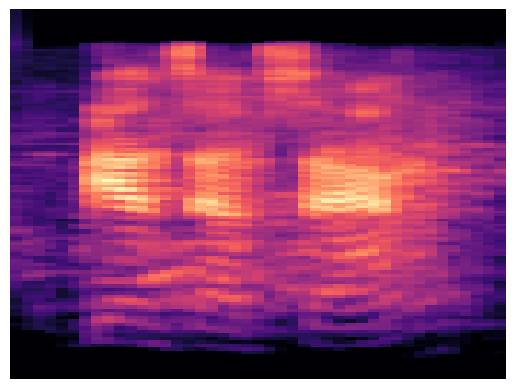

In [ ]:
# vẽ spectrogram của phép tăng cường "High pass filter"
augs = 'HighPassFilter'
augment = Compose(get_augs(augs))
wav = augment(samples=y, sample_rate=sr)

fig, ax = plt.subplots()
plt.axis('off')
M = librosa.feature.melspectrogram(y=wav, sr=sr)
M_db = librosa.power_to_db(M, ref=np.max)
img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=ax)

# tăng cường dữ liệu


tạo danh sách các file cần tăng cường


In [ ]:
import glob
import pandas as pd
import os
def generate_csv(folder, label):
    folder_name = os.path.basename(folder)
    labels = list(label)
    print(labels)
    # generate CSV file
    df = pd.DataFrame(columns=["filepath","label"])
    i = 0
    for label in labels:
          for filepath in glob.glob(os.path.join(folder,label, "*.wav")):
            df.loc[i] = [filepath,label]
            i += 1
    output_file = f"{folder_name}.csv"
    print("Saving", output_file)
    df.to_csv(output_file)
dir_folder = '/content/drive/MyDrive/wakeword'
generate_csv(dir_folder ,{'noise'})
metadata_filename = "wakeword.csv"
# load CSV files as DataFrames
metadata = pd.read_csv(metadata_filename)
metadata.tail()

thực hiện tăng cường các file trong danh sách


In [ ]:
import soundfile as sf
import shutil
augs = ['Gain','AirAbsorption','NoiseInjection','PitchShifting','TimeStretching','Padding','BandPassFilter','Gain',
        'TimeMask','HighPassFilter','ClippingDistortion','AirAbsorption','Trim']
from tqdm import tqdm
i=0
for index_num,row in tqdm(metadata.iterrows()):
    filename = str(row["filepath"])
    label=row["label"]
    folder = '/content/drive/MyDrive/aug_dataset/augment2/noise'
    os.makedirs(folder, exist_ok = True)
    for aug in augs:
      y, sr = librosa.load(filename,sr=16000)
      augment = Compose(get_augs(aug=aug))
      wav = augment(samples=y, sample_rate=sr)
      sf.write(str(i)+'.wav', wav, 16000, subtype='PCM_16')
      shutil.move(str(i)+'.wav', folder)
      i+=1